In [ ]:
'''
import cv2

def rotate_video(input_path, output_path, angle=90):
    # Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) if angle in [90, 270] else int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) if angle in [90, 270] else int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change codec if needed
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Rotate frame
        if angle == 90:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            frame = cv2.rotate(frame, cv2.ROTATE_180)
        elif angle == 270:
            frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

        out.write(frame)

    cap.release()
    out.release()
    print(f"Rotated video saved as {output_path}")

    '''

Chest point initialized at: (414, 137)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
109
109
109
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
224
224
225
226
226
226
226
226
226
227
228
229
230
231
231
231
231
232
233
234
235
236
236
236
236
236
237
238
239
240
241
242
243
244
245
246
247
248
249
2

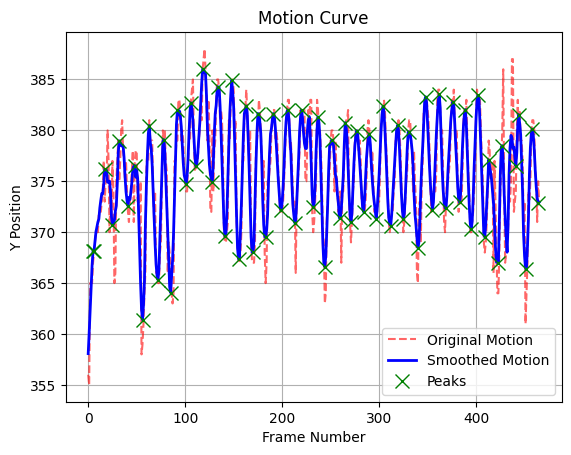

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import deque
import time
import math
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt

# Constants
MIN_KEYPOINT_CONFIDENCE = 0.1  # Minimum confidence for keypoints
RESCUER_PROXIMITY_THRESH = 0.3  # Relative distance threshold for rescuer detection

# Keypoint indices (YOLO pose model)
LEFT_SHOULDER = 5
RIGHT_SHOULDER = 6
LEFT_WRIST = 9
RIGHT_WRIST = 10

# Global variables
chest_point = None  # (x, y) in image-space coordinates
firstTimeRotated = True
midpoints_list = []
y_smoothed = []
peaks = []

model = YOLO("yolo11n-pose.pt")

def detect_chest_landscape(frame):
    results = model(frame, verbose=False)
    if not results or len(results[0].keypoints.xy) == 0:
        return None

    keypoints = results[0].keypoints
    boxes = results[0].boxes
    confs = keypoints.conf  # shape: [num_persons, 17]

    for i, (kp, box) in enumerate(zip(keypoints.xyn, boxes.xywh)):
        x, y, w, h = box
        if h < w * 1.2:  # Not vertical enough
            continue

        if confs[i][LEFT_SHOULDER] < MIN_KEYPOINT_CONFIDENCE or confs[i][RIGHT_SHOULDER] < MIN_KEYPOINT_CONFIDENCE:
            continue

        left_shoulder = kp[LEFT_SHOULDER][:2].cpu().numpy()  # Convert tensor to numpy array
        right_shoulder = kp[RIGHT_SHOULDER][:2].cpu().numpy()  # Convert tensor to numpy array

        return (left_shoulder, right_shoulder)

    return None

def initialize_chest_detection(cap):
    global chest_point
    shoulder_samples = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    for i in range(15):
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)
        if not results or len(results[0].keypoints.xy) == 0:
            continue

        debug_frame = results[0].plot()
        shoulders = detect_chest_landscape(frame)

        if shoulders:
            left_shoulder, right_shoulder = shoulders
            shoulder_samples.append((left_shoulder, right_shoulder))

            lx, ly = (left_shoulder * np.array([frame.shape[1], frame.shape[0]])).astype(int)
            rx, ry = (right_shoulder * np.array([frame.shape[1], frame.shape[0]])).astype(int)

            cv2.circle(debug_frame, (lx, ly), 5, (0, 0, 255), -1)
            cv2.circle(debug_frame, (rx, ry), 5, (0, 0, 255), -1)
            cv2.putText(debug_frame, f"CHEST pts - Frame {i+1}", (lx, ly - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                        

        cv2.imshow("Chest Detection Debug", debug_frame)
        if cv2.waitKey(400) == ord('q'):
            break

    if shoulder_samples:
        avg_left = np.median([s[0] for s in shoulder_samples], axis=0)
        avg_right = np.median([s[1] for s in shoulder_samples], axis=0)

        avg_left_px = avg_left * np.array([frame.shape[1], frame.shape[0]])
        avg_right_px = avg_right * np.array([frame.shape[1], frame.shape[0]])

        midpoint = (avg_left_px + avg_right_px) / 2
        shoulder_dist = np.linalg.norm(avg_left_px - avg_right_px)

        # Move downward by 20% of shoulder distance (tunable)
        downward_offset = 0.4 * shoulder_dist
        chest_point = (int(midpoint[0]), int(midpoint[1] + downward_offset))
        print(f"Chest point initialized at: {chest_point}")
        cv2.circle(frame, chest_point, 8, (0, 55, 120), -1)
        cv2.putText(frame, "AYWA", (chest_point[0] + 5, chest_point[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

    cv2.destroyWindow("Chest Detection Debug")


def find_rescuer(pose_results, frame_shape):
    if not pose_results or len(pose_results[0].boxes) == 0:
        return None

    boxes = pose_results[0].boxes.xywh.cpu().numpy()
    horizontal_objects = []

    for box in boxes:
        x, y, w, h = box
        if w > h * 1.5:
            horizontal_objects.append((x, y, w, h))

    if not horizontal_objects:
        return None

    people = []
    for i, box in enumerate(boxes):
        x, y, w, h = box
        if h > w * 1.2 and len(pose_results[0].keypoints) > i:
            people.append((i, x, y))

    if not people:
        return None

    min_distance = float('inf')
    rescuer_idx = None

    for (i, px, py) in people:
        for (hx, hy, hw, hh) in horizontal_objects:
            distance = np.sqrt(((px - hx) / frame_shape[1]) ** 2 + ((py - hy) / frame_shape[0]) ** 2)
            if distance < min_distance and distance < RESCUER_PROXIMITY_THRESH:
                min_distance = distance
                rescuer_idx = i

    return rescuer_idx


def smoothMidpoints():
    """
    Applies Savitzky-Golay filter to smooth the y-coordinates of midpoints.
    """
    global midpoints_list
    global y_smoothed

    if len(midpoints_list) > 5:  # Ensure enough data points for smoothing
        midpoints_list = np.array(midpoints_list)
        y_smoothed = savgol_filter(midpoints_list[:, 1], window_length=10, polyorder=2, mode='nearest')
    else:
        y_smoothed = midpoints_list[:, 1]  # Use original data if not enough points


# Detect the peaks of the motion curve
def detectPeaks():
    """
    Detects the peaks of the motion curve.
    """

    global y_smoothed
    global peaks

    if y_smoothed.size == 0:
        print("No smoothed values found.")
        return  # Do nothing if there are no smoothed values
            
    peaks_max, _ = find_peaks(y_smoothed, distance=10)
    peaks_min, _ = find_peaks(-y_smoothed, distance=10)
    peaks = np.sort(np.concatenate((peaks_max, peaks_min)))

def plotMidpoints():
    """
    Plots the original and smoothed y-coordinates of the midpoints.
    """
          
    global midpoints_list
    global y_smoothed   
    global peaks


    if midpoints_list.size == 0:
        return  # Do nothing if there are no midpoints
    
    y = midpoints_list[:, 1]

    # Plot motion curve
    plt.plot(y, label="Original Motion", color="red", linestyle="dashed", alpha=0.6)
    plt.plot(y_smoothed, label="Smoothed Motion", color="blue", linewidth=2)

    
    if peaks.size > 0:
        plt.plot(peaks, y_smoothed[peaks], "x", color="green", markersize=10, label="Peaks")
    else:
        print("No peaks detected.")
    
    plt.xlabel("Frame Number")
    plt.ylabel("Y Position")
    plt.title("Motion Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
          
          
def process_frame(frame, width, height):
    global chest_point
    global firstTimeRotated
    global midpoints_list
    
    rotated = False

    if width > height:
        # Rotate the frame 90 degrees clockwise to portrait mode
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        rotated = True

    # Process the frame using YOLO model
    results = model(frame, verbose=False)

    if not results:
        return frame

    annotated_frame = results[0].plot()

    if rotated and firstTimeRotated:
        # Adjust chest point for rotated frame
        if chest_point is not None:
            chest_point = (height - chest_point[1], chest_point[0])
            firstTimeRotated = False

    # Draw the chest point
    cv2.circle(annotated_frame, chest_point, 8, (255, 0, 0), -1)
    cv2.putText(annotated_frame, "CHEST", (chest_point[0] + 5, chest_point[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Find and draw rescuer
    rescuer_idx = find_rescuer(results, frame.shape[:2])

    if rescuer_idx is not None:
         #Find the rescurer midpoint of writss and append it to a list
        left_wrist = results[0].keypoints.xyn[rescuer_idx][LEFT_WRIST][:2].cpu().numpy()
        right_wrist = results[0].keypoints.xyn[rescuer_idx][RIGHT_WRIST][:2].cpu().numpy()

        #print(f"Left wrist: {left_wrist.type()}")
        #print(f"Right wrist: {right_wrist.type()}")

        wrist_midpoint = (left_wrist + right_wrist) / 2

        #print(f"Midpoint: {wrist_midpoint.type()}")

        # Draw the midpoint
        wrist_midpoint_px = (wrist_midpoint * np.array([frame.shape[1], frame.shape[0]])).astype(int)


        #print(f"Rescuer wrist midpoint: {wrist_midpoint_px.type()}")
        

        # Append the midpoint to the list
        midpoints_list.append(wrist_midpoint_px)
        
        cv2.circle(annotated_frame, tuple(wrist_midpoint_px), 8, (0, 255, 0), -1)
        cv2.putText(annotated_frame, "MIDPOINT", (wrist_midpoint_px[0] + 5, wrist_midpoint_px[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


        boxes = results[0].boxes.xyxy.cpu().numpy()
        x1, y1, x2, y2 = boxes[rescuer_idx].astype(int)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(annotated_frame, "RESCUER", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return annotated_frame


def main():
    cap = cv2.VideoCapture("video_5.mp4")
    if not cap.isOpened():
        print("Error opening video file.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    initialize_chest_detection(cap)

    cv2.namedWindow("Rescue Analysis", cv2.WINDOW_NORMAL)
    pTime = 0  # Previous time for FPS calculation
    while True:
        
        ret, frame = cap.read()
        if not ret:
            break
        
        output_frame = process_frame(frame, width, height)
        print(len(midpoints_list))
        cTime = time.time()
        fps = 1 / (cTime - pTime) if pTime else 0
        pTime = cTime
        
        cv2.putText(output_frame, f"FPS: {int(fps)}", (70, 50), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
        cv2.imshow("Rescue Analysis", output_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    smoothMidpoints()
    detectPeaks()
    plotMidpoints()

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
